[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jussippjokinen/CogMod-Tutorial/blob/main/03-Modelbuilding/Go_Nogo.ipynb)


In [45]:
# Install the files to local.
# Please note that the go / no go model we are using here is still being developed,
# and should not yet be adapted for other work! The development is in close collaboration
# with the Commotions project at Leeds, led by Gustav Markkula, and collaborated with Aravinda Srinivasan.
! wget https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/animate_trace.py
! wget https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/driver_agent_physics.py
! wget https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/go_nogo.py
! wget https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/physics_env.py

--2025-11-09 16:41:00--  https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/animate_trace.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1798 (1.8K) [text/plain]
Saving to: ‘animate_trace.py.2’

animate_trace.py.2  100%[===================>]   1.76K  --.-KB/s    in 0s      

2025-11-09 16:41:00 (31.2 MB/s) - ‘animate_trace.py.2’ saved [1798/1798]

--2025-11-09 16:41:01--  https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/driver_agent_physics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent

In [46]:
# Install the required library.
! pip install stable_baselines3

# Module 3: Building a Model

In this module, we take a step-by-step walktrough of how to create a computational rational (CR) model using deep reinforcement learning (RL). This notebook does not cover the full workflow of CR modeling, which is long and detailed. It can be found here, make sure to follow it when creating your own models. For the purpose of this notebook, the simplified workflow looks like this:

1. Define the goals.

2. Define the environment.

3. Define the cognitive limitations.

4. Derive the optimal behavior.

5. Inspect model validity.

The model will be defined according to the standard CR flow of information.

<img src="https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/corati_model.png" alt="Corati Modeling" width="700">


# 1. Define the agent's goals

The task explored in this notebook is a fairly simple one: in a junction, when turning against the oncoming traffic, the driver needs to decide if they can go, or if they need to wait for an oncoming car before they can cross. In left-handed traffic, this means that the agent driver is turning right. Here is the illustration:

<img src="https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/03-Modelbuilding/go_nogo_task.png" alt="Go / No go task" width="300">

The agent (the yellow car) has two main goals:

1. **Proceed** to the destination by turning left.

2. Drive **safely**, avoiding collisions.

First, we need to analyze these goals. First, the agent wants to drive efficiently and not get stuck on the road for too long. They probably want to get to their destination, and also they would be blocking the traffic behind them if they wait unreasonably long. So we can analyse these goals into a reward function.

1. When the agent **turns successfully**, there is a positive reward.
2. For this positive reward, there is a penalty of **time spent** waiting.
3. For a **collision**, there is a negative reward.

**Task 1**. Discuss alternative goals that the driver may have. Can you specify
 them in terms of the scalar reward function?

# 2. Define the task environment

For simplicity, the environment has only two cars, in a 2-dimensional environment: the agent's car and the oncoming car. The cars are particles that have their individual `(x,y)` coordinates. The agent's car is stationary until the agent decides to turn left. The oncoming car has a variable position, which moves along the y-axis of the environment according to its velocity, which is fixed constant. A collision is detected if the vehicles are too close to each other regardless of their velocities.

In [47]:
# Let's define an environment and an agent and see how it works.
import physics_env
import driver_agent_physics

e = physics_env.physics_env()
agent = driver_agent_physics.driver_agent_physics(e, observation_var = 0) # a full observer: no noise
agent.reset()

({'distance': [0.15828265917217124],
  'speed': [0.298],
  'acceleration': [0],
  'passed': [0],
  'distance_var': [0],
  'ticks': [0.0]},
 {})

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


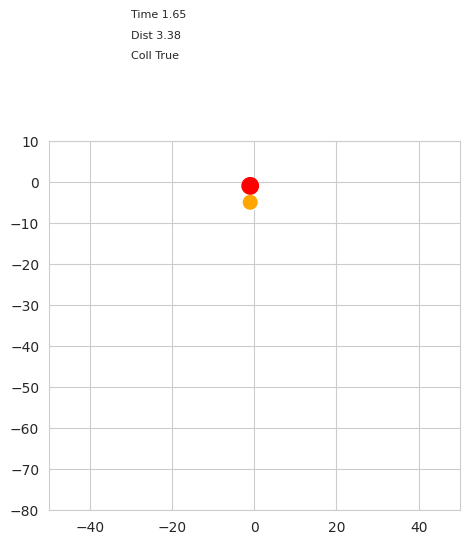

In [48]:
# Let's wait for 20 ticks, then go.
from IPython.display import HTML, display
import animate_trace

agent.reset(y_start = -20)
agent.env.save_trace = True
for i in range(20):
    agent.step(0)
agent.step(1)
agent.env.save_trace = False

HTML(animate_trace.animate_trace(agent.env.trace, get_anim = True, x_lim = [-50,50], y_lim = [10,-80]).to_jshtml())

**Task 2.** Change the starting distance of the incoming car. Try to collide the cars! (Note that the y-coordinate needs to be negative.)

# 3. Define the relevant cognitive bounds of the agent

The agent must make a decision to go (turn left) or wait. It bases this decision on a noisy observation of the oncoming car's distance to the agent's car. If the distance is long enough, the agent can go and save time. If the car is too close, the agent must wait for it to pass to avoid a collision.

For modeling noisy observation, we will be using the formula from Markkula, et al. (2022). Explaining human interactions on the road requires large-scale integration of psychological theory. https://psyarxiv.com/hdxbs/

$ \hat{D} = D_{oth} \cdot \left(1 - \frac{h}{D \cdot \tan \left(\arctan \left(\frac{h}{D}\right) + \sigma \right)}\right) $,

where $ \hat{D} $ is a noisy observation of distance, $D_{oth}$ is the oncoming car's longitudinal distance to the crossing point, and $h$ is the observer's eye height over ground (1.5m). The important parameter here is $\sigma$, which describes how noisy the observation is.

The noisy observation is not used directly, but via Bayesian filtering. This considers prior belief about the distance and integrates the new observation with it. Additionally, we represent the uncertainty associated with the belief.

Before deriving the optimal behavior, we want to establish what hypotheses our model in fact makes, so that we can then assess the plausibility of model predictions against them. While modeling is virtually always interactive and the hypotheses might develop during iteration, but it is important to have a strong initial assumption about how our model will behave. Here are initial proposals, which would then be turned into exact, testable hypotheses:

P1. For a non-noisy (full) observer, there is a precise distance: if the other car is farther than this distance, the agent decides to go. If the other car is closer, the agent chooses to wait. If the car has passed, the agent always goes.

P2. For a noisy (partial) observer, the decision to go is more conservative and uncertain: the distance that determines the go / no go decision is larger, and due to noisy estimates, the choice is probabilistic given distance.

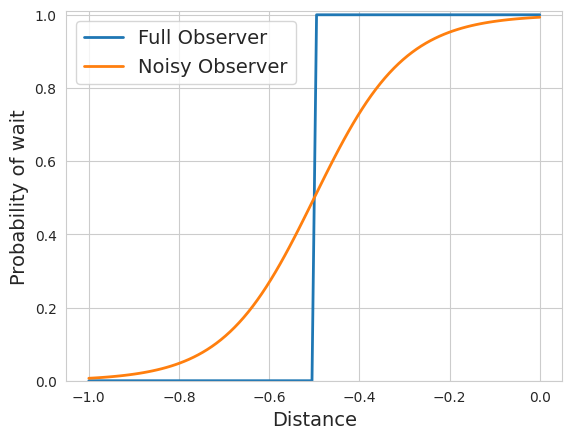

In [49]:
# Here is a theoretical illustration of our proposals.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
x1 = np.linspace(-1, 0, 100)
x2 = np.linspace(-1, 0, 100)
y1 = np.zeros(100)
y1[50:] = 1
y2 = 1 / (1 + np.exp(-10*(x2+0.5)))
plt.plot(x1, y1, label='Full Observer', linewidth = 2)
plt.plot(x2, y2, label='Noisy Observer', linewidth = 2)
plt.ylim(0, 1.01)
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Probability of wait', fontsize=14)
plt.legend(fontsize=14)
plt.show()

**Task 3.** Discuss what the hypothesis actually means. What do the lines tell us?

## How does the noisy observation happen?

The observation of the approaching vehicle distance is noisy. In practice, we simulate noisy observation by taking the true observation and then adding noise from a normal distribution, according to some parameter sigma. However, instead of using the returned noisy value as such, we assume that the human visual system exploits the fact that each noisy value is based on the true value, and the noise comes from a known distribution. We can then use a Kalman filter to approximate the true state. With more observations, the approximation becomes better. In our simulation, this is confounded by the formula above, which states that observations get better as the distance shortens. Let's investigate this behavior.

In [50]:
import math
import numpy as np

# Here is the formula for making an observation, given distance.
def noisy_observation(D):
    # D = distance in meters
    d_oth = D+2 # crossing point distance, this is a crude approximation to simplify our exercise
    h = 1.5 # eye height
    observation_var = 0.1 # this is the sigma
    distance_var = d_oth * (1 - h / (D*math.tan(math.atan(h/D) + observation_var)))
    observed_distance = np.random.normal(D, distance_var)
    return observed_distance, distance_var


# Let's see what kinds of observations we make from the true distance of 50 m
for i in range(10):
    print(noisy_observation(50)[0])

42.0653263363905
77.45630944692049
96.08563626986285
-25.58951219106453
72.02732838875144
19.267868892814665
98.13961912160688
110.39178901993809
16.232333752279516
79.19956402930761


In [51]:
# So, that's not a very reliable observation! Here is the Kalman filter, let's see how it helps.
def kalman_update(prior_mean, prior_var, observation, s):
        observation_gain = 1
        kalman_gain = prior_var * observation_gain / (prior_var * observation_gain**2 + s**2)
        posterior_mean = prior_mean + kalman_gain * (observation - prior_mean)
        posterior_var = (1 - kalman_gain * observation_gain) * prior_var

        return posterior_mean, posterior_var

# Then, let's update both mean and variance estimates multiple times
distance_prior = 100 # set an uninformed prior
distance_var_prior = 1000 # basically a uniform prior
for i in range(20):
    d, s = noisy_observation(50)
    distance_post, distance_var_post = kalman_update(distance_prior, distance_var_prior, d, s)
    # Store result
    print(distance_post)
    # Set the posterior as the new prior
    distance_prior = distance_post
    distance_var_prior = distance_var_post

69.02450172263372
69.95783607060841
57.55150452958959
59.65788517375002
61.21350325311699
61.4209192879994
55.24763768859316
53.279406884841826
54.18202074655309
51.25259430318572
45.86791617658987
46.751766351030014
50.32209225985421
47.97621394552996
46.9723262544065
47.820074695426825
47.95149738419221
46.76169162681578
47.86348541914204
44.29199740708857


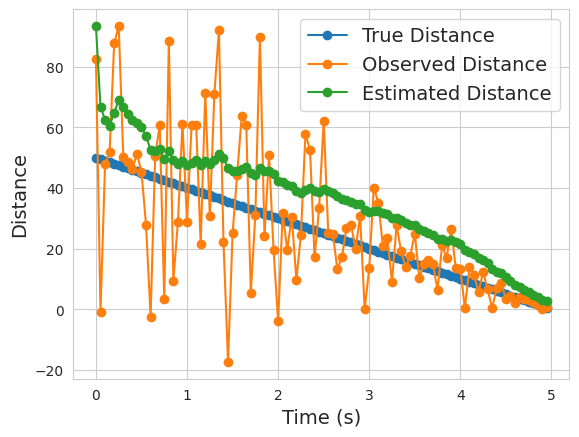

In [52]:
# Can we visualize it? Let's assume a constant velocity of 0.5 m per observational "tick".
# Assuming one tick is 0.05s, this is 10m/s = 36km/h
import matplotlib.pyplot as plt
import seaborn as sns

true_d = 50
distance_prior = 100 # set an uninformed prior
distance_var_prior = 1000 # basically a uniform prior
velocity = 0.5
data = []
for i in range(100):
    d, s = noisy_observation(true_d)
    distance_post, distance_var_post = kalman_update(distance_prior, distance_var_prior, d, s)
    # Store result
    data.append([true_d, d, distance_post])
    # Set the posterior as the new prior
    distance_prior = distance_post
    distance_var_prior = distance_var_post
    # "Move" the approaching vehicle
    true_d -= velocity

# Make the plot
true_distance, observed_distance, estimated_distance = zip(*data)
index = np.array(range(len(data))) / 20 # make into seconds
sns.set_style('whitegrid')
plt.plot(index, true_distance, label='True Distance', linestyle='-', marker='o')
plt.plot(index, observed_distance, label='Observed Distance', linestyle='-', marker='o')
plt.plot(index, estimated_distance, label='Estimated Distance', linestyle='-', marker='o')

plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Distance', fontsize = 14)
plt.legend(loc='best', fontsize = 14)

plt.show()

**Task 3.1** Change the prior (distance and variance) and investigate how that changes the convergence of the posterior over time. You can also try changing the velocity and starting distance.

# 4. Derive optimal policy

For establishing the (bounded) optimal policy for the ideal and noisy observer agents, we will be using Proximal Policy Optimization, which is an on-policy deep RL algorithm. This notebook uses the OpenAI Stable Baselines implementation, but there are others as well. https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

Before we can derive the optimal policy, the environments (both internal and external) need to be modeled using Markov Decision Process (**MDP**, or in our case, due to partial observability, we are defining a **POMDP**). We won't go into the details of how the external driving environment is modeled, but it is a simple stepwise simulator, that for each time step (0.05 seconds by default), "ticks" the environment forward by moving the upcoming car's y-position according to its velocity, and in case the agent decides to go, moves it towards the side road along a predefined trajectory, in a constant velocity as well.

For the internal environment, we need to model the belief update for distance of the oncoming car, given the equation and filtering that were defined above. All relevant information must be represented as the agent's belief such that we can pass that, along with the reward signal, to the RL agent for learning the optimal policy.

In [53]:
# Here are the action and observation spaces of the agent

from gymnasium.spaces import Discrete, Dict, Box

action_space = Discrete(2)

# Note that all observatons are normalized between 0 and 1.
observation_space = Dict(
    spaces = {
        "distance": Box(0, 1, (1,)),
        "passed": Box(0, 1, (1,)),
        "distance_var": Box(0, 1, (1,)),
        "speed": Box(0, 1, (1,)),
        "acceleration": Box(0, 1, (1,)),
        "ticks": Box(0, 1, (1,))
    })

# Sample the action space:
print("A small sample of actions:", action_space.sample(), action_space.sample(), action_space.sample())
print("One sample of observation space:", observation_space.sample())

A small sample of actions: 0 1 1
One sample of observation space: {'acceleration': array([0.08000933], dtype=float32), 'distance': array([0.11922034], dtype=float32), 'distance_var': array([0.5591535], dtype=float32), 'passed': array([0.36803558], dtype=float32), 'speed': array([0.95689774], dtype=float32), 'ticks': array([0.34469596], dtype=float32)}


So, the environment simulation works as intended. Let's now take a look at the reward function. Remember our definition:

1. When the agent **turns left successfully**, there is a positive reward.
2. For this positive reward, there is a penalty of **time spent** waiting.
3. For a **collision**, there is a negative reward.

We will establish the reward function along with one step of the model to see what actually happens when we step.

In [54]:
def step(self, action):
    self.reward = 0

    # NO-GO (wait)
    if action == 0:
        self.env.tick()
        self.ticks += 1
        # small reward for patience (humans tend to wait)
        self.reward += 0.3

        # waiting too long becomes stressful → increasing penalty
        if self.ticks > self.max_ticks:
            self.reward -= 50
            self.done = True
        elif self.env.get_distance() > self.max_distance:
            self.reward -= 50
            self.done = True

    # GO
    if action == 1:
        min_dist = self.env.get_min_distance()
        self.env.tick()
        self.ticks += 1

        # reward completion, scaled to encourage earlier decision
        self.reward = 20 - 0.6 * self.ticks

        if self.collision:
            self.reward = -2000  # huge collision penalty

        else:
            # Penalize extremely narrow margins → more cautious behavior
            if min_dist < 3.0:
                self.reward -= 30

        # aggressive / late start discomfort penalty
        if self.distance_at_go < 10.0:
            self.reward -= 10

    self.belief = self.get_belief()
    return self.belief, self.reward, self.done, False, {}


In [ ]:
# Let's make and train the full observer agent.
import go_nogo
full_obs_agent = go_nogo.make_agent(sigma = 0, iters = 10)
# In the output:
# i = training iteration
# t = number of ticks (1 tick = 0.05s)
# r = average reward (10 is max)
# d = average distance of the two vehicles at the time of go (in meters)
# w = frequency of waits (agent waited the other car to pass before going)
# c = frequency of collisions


i	t	r	d	w	c


In [ ]:
# To keep training the agent without initializing it anew, use this.
# Commented out so it won't run when running all cells
# go_nogo.retrain_agent(full_obs_agent, iters = 10)

In [ ]:
# Let's investigate if it has found a policy for the different distances.
# Keep an eye on the "critical" y_start at around -13.
HTML(go_nogo.animate_agent(full_obs_agent, y_start = -13.8, get_anim = True).to_jshtml())

In [ ]:
# Train the noisy observer. Use more iters due to a more difficult learning task.
noisy_obs_agent = go_nogo.make_agent(sigma = 0.1, iters = 15)

In [ ]:
# To keep training the agent without initializing it anew, use this.
# Commented out so it won't run when running all cells
go_nogo.retrain_agent(noisy_obs_agent, iters = 10)

In [ ]:
# Let's investigate if it has found a policy for the different distances.
# Keep an eye on the "critical" y_start at around -13.
HTML(go_nogo.animate_agent(noisy_obs_agent, y_start = -13.8, get_anim = True).to_jshtml())

**Task 4.** Try to find out the critical distance where the two models, full and partial/noisy observer, differ in their go/no go policy.

# 5. Inspect model validity

After having converged the model to an optimal policy, our aim is to utilize it for generating simulations of task behavior. The evaluation of the model's validity encompasses multiple stages, see the workflow.pdf draft for these. Here, we concentrate solely on its face validity, which addresses whether the model aligns with our initial predictions.

Starting the model's validity assessment with face validity tests is a useful practice, as any discrepancies between the model's performance and our hypotheses at this stage may indicate issues with either the model's specification or our modeling assumptions. This is frequently an iterative procedure, during which we may observe the model's divergence from our expectations, resulting in identifying inadequate definitions of objectives, task environment, or cognitive constraints.

Once the model successfully demonstrates face validity, it should be subjected to a rigorous validation process, wherein its predictions are compared against human data or some alternative benchmarks. The model should e.g., generate accurate summary statistics (across a broader human population), be capable of replicating individual performance by adjusting specific parameters, and operate reasonably under changes in the environment. The specific validation depends always on the details of the modeling work.

In [ ]:
# Run an experiment for obtaining multiple samples from each agent.
def wait_or_go_experiment(agent, y_range, n = 100, deterministic = False):
    data = []
    agent.env.veh1_straight_start_y_range = y_range
    for i in range(n):
        _, _, _, w, c = agent.run_episode(deterministic = deterministic)
        data.append([agent.observation_var, agent.env.y_start, w, c])

    agent.env.veh1_straight_start_y_range = [-25,-2] # return back to original
    return data

import pandas as pd

# Increase n to e.g., 2000 to get more robust final image, but note that it takes longer to run.
data = wait_or_go_experiment(full_obs_agent, y_range = [-5,-25], n = 500, deterministic = True)
data = data + wait_or_go_experiment(noisy_obs_agent, y_range = [-5,-25], n = 500, deterministic = True)
columns = ['sigma', 'y_start', 'wait', 'collision']
df = pd.DataFrame(data, columns=columns)

In [ ]:
# Visualize individual go/no go decisions between different sigma models for various y_ranges.

import numpy as np
import matplotlib.pyplot as plt

# Note: this is a bit slow and dirty, gets slow with a lot of data. Only use for diagnosis.
def plot_data(df):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define custom colors and markers based on wait and collision values
    colors = {0: 'red', 1: 'blue'}
    markers = {0: 'o', 1: 'x'}

    # Create a dictionary to store the labels we've already added to the legend
    labels_added = {}

    for index, row in df.iterrows():
        sigma = row['sigma']
        y_start = row['y_start']
        wait = row['wait']
        collision = row['collision']
        label = f'Wait: {wait}, Collision: {collision}'

        # Add scatter plot point with custom color and marker
        ax.scatter(
            y_start,
            sigma,
            marker=markers[collision],
            color=colors[wait],
            label=label if label not in labels_added else "",
            alpha=0.7
        )

        # Remember that we've added this label to the legend
        labels_added[label] = True

    ax.set_xlabel('y_start')
    ax.set_ylabel('sigma')
    ax.legend(title="Wait, Collision", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Impact of y_start on wait and collision for different sigma agents')
    plt.show()

plot_data(df)

**Task 5.** Discuss the figure. What are we seeing here? What is the difference between the two models and how is it connected to the original hypotheses made?

In [ ]:
# Visualize the probability of go/no go as the function of y_start, between different sigmas.

# Change smoothness to larger to get less raggedy lines.
# Also, increase the N in the experiment above to get more observations.
smoothness = 1

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

def estimate_probability(df, sigma, y_start_values, window_size=1, collision = False):
    sub_df = df[df['sigma'] == sigma].sort_values('y_start')
    probabilities = []

    for y_start in y_start_values:
        window_df = sub_df[(sub_df['y_start'] >= y_start - window_size / 2) & (sub_df['y_start'] <= y_start + window_size / 2)]
        probability = window_df['collision' if collision else 'wait'].sum() / len(window_df)
        probabilities.append(probability)

    return probabilities

def smooth_probabilities(probabilities, sigma=1):
    return gaussian_filter1d(probabilities, sigma=sigma)

def plot_probability_lines(df, collision = False):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    y_start_range = np.linspace(df['y_start'].min(), df['y_start'].max(), num=500)

    for sigma in df['sigma'].unique():
        probabilities = estimate_probability(df, sigma, y_start_range, collision = collision)
        smoothed_probabilities = smooth_probabilities(probabilities, sigma = smoothness)
        ax.plot(y_start_range, smoothed_probabilities, label=f'{sigma}', linewidth=2)

    ax.set_xlabel('y_start', fontsize=14)
    ax.set_ylabel('Probability of Wait', fontsize=14)
    ax.legend(title="Sigma", loc="upper left", fontsize=12, title_fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Probability of Wait across y_start by sigma', fontsize=16)
    plt.grid(alpha=0.5)
    plt.show()

plot_probability_lines(df)

# Extra: Changing the reward function

With the model right above, we observe that the behavior follows our theoretical hypothesis, however it emphasizes is risk-taking in a way that does not feel human-like.

The next step in modeling is to start adjusting the reward function for the desired performance. It sounds theoretically implausible that a collision is as "bad" (negatively rewarding) as a successful task is "good" (positively rewarding). We can change the model's predicted behavior by adjusting the relative strengths of the positive reward from a successful task and negative reward from a collision. The original values were 10 and -10, respectively.

In [ ]:
# Set collision penalty to a considerable higher value. 'p' for 'penalty'
# For ease of illustration using the old code, we set sigma to a slightly different value, which won't practically impact the simulation

noisy_obs_agent_p = go_nogo.make_agent(sigma = 0.1001, iters = 15, collision_reward = -500)

In [ ]:
# Collect data for all three models (full observation, noisy observation, and noisy observation with a large collision penalty
# Bigger range for start values of the other car for clearer visualization.

data = wait_or_go_experiment(full_obs_agent, y_range = [-5,-40], n = 1000, deterministic = True)
data = data + wait_or_go_experiment(noisy_obs_agent, y_range = [-5,-40], n = 1000, deterministic = True)
data = data + wait_or_go_experiment(noisy_obs_agent_p, y_range = [-5,-40], n = 1000, deterministic = True)

columns = ['sigma', 'y_start', 'wait', 'collision']
df = pd.DataFrame(data, columns=columns)